# Analysis of TED Talk Ratings #

## Introduction ##

In this analysis I try to quantify the impact of various factors on the rating of a TED talk.

First we can load the data: 

In [1]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
import ast

# Load in Python libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plot
from textblob import TextBlob
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD
from scipy.stats import gaussian_kde
import re
import ast
import random
from sklearn import preprocessing

matplotlib.style.use('ggplot')

df = pd.read_csv('ted_main.csv')

%matplotlib inline

Using TensorFlow backend.


## Measuring Ratings ##

To perform this analysis, we need a quantitative definition of a talk's rating. In the data set, such a factor exists, but it is split into various qualitative descriptions. Therefore, we define a measure of aggregate ratings as the sum of some descriptions and the difference of some others. These are considered positive: 

* Funny
* Courageous
* Beautiful
* Informative
* Inspiring
* Fascinating
* Ingenious
* Persuasive
* Jaw-dropping

These are considered negative: 

* Confusing
* Unconvincing
* Longwinded
* Obnoxious
* OK

In [2]:
df['ratings'] = df['ratings'].apply(lambda x: eval(str(x)))
df['aggregateRatings'] = df['ratings'].apply(lambda x: \
                                            x[0]['count']+ \
                                            x[1]['count']- \
                                            x[2]['count']+ \
                                            x[3]['count']- \
                                            x[4]['count']- \
                                            x[5]['count']+ \
                                            x[6]['count']+ \
                                            x[7]['count']+ \
                                            x[8]['count']+ \
                                            x[9]['count']+ \
                                            x[10]['count']+ \
                                            x[11]['count']- \
                                            x[12]['count']- \
                                            x[13]['count'])
ar = df['aggregateRatings']

## Preliminary Analysis ##

We first examine the relationship between this aggregate rating measure and some factors present in the data set. First up is the number of languages:

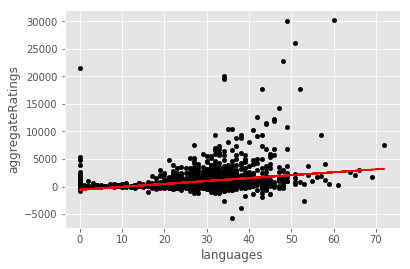

In [4]:
df.plot.scatter(x='languages',y='aggregateRatings',color='black')
#define convenience function for trend lines
def plotTrendLine(x,y,data=df,color='red',logx=False,logy=False):
    oldx = np.reshape(data[x].values,(-1,))
    oldy = np.reshape(data[y].values,(-1,))
    tempx = oldx
    tempy = oldy
    if logx:
        tempx = np.log10(tempx)
    if logy:
        tempy = np.log10(tempy)
    idx = np.isfinite(tempx) & np.isfinite(tempy)
    z = np.polyfit(tempx[idx],tempy[idx],1)
    tempy = z[0]*tempx+z[1]
    plot.plot(oldx,tempy,color=color)
    return z
plotTrendLine('languages','aggregateRatings');

We see that there is a slight correlation between languages and ratings - which doesn't seem immediately intuitive. Possibly this is really attributable to views and comments. 

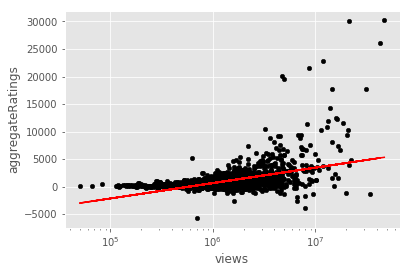

In [5]:
df.plot.scatter(x='views',y='aggregateRatings',color='black')
plotTrendLine('views','aggregateRatings',logx=True);
plot.xscale('log')

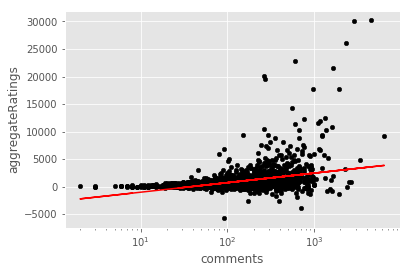

In [6]:
df.plot.scatter(x='comments',y='aggregateRatings',color='black')
plotTrendLine('comments','aggregateRatings',logx=True);
plot.xscale('log')

Again, there is a general positive trend in both cases, with some outliers tending towards more negative ratings. We can conlude rather naturally that talks people like seem to be more viewed and commented on, and thus rated more highly. However, this also introduces a rating bias toward more highly-viewed talks. Thus, we define a new data column which is average aggregate rating: 

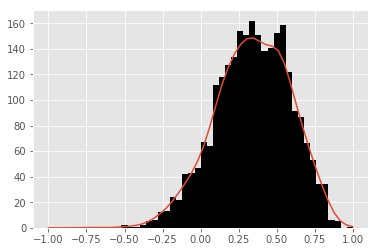

In [7]:
df['totalRatings'] = df['ratings'].apply(lambda x: \
                                            x[0]['count']+ \
                                            x[1]['count']+ \
                                            x[2]['count']+ \
                                            x[3]['count']+ \
                                            x[4]['count']+ \
                                            x[5]['count']+ \
                                            x[6]['count']+ \
                                            x[7]['count']+ \
                                            x[8]['count']+ \
                                            x[9]['count']+ \
                                            x[10]['count']+ \
                                            x[11]['count']+ \
                                            x[12]['count']+ \
                                            x[13]['count'])

df['avgPerRating'] = df['aggregateRatings']/df['totalRatings']
plot.hist(x=df['avgPerRating'],bins=50,range=(-1,1),color='black')
#convenience function for density curve plotting
def plotDensityCurve(x,linspace,covariance_factor=0.25,multiplier=1,data=df,color='red'):
    if data is not None:
        tempx = np.reshape(data[x].values,(-1,))
    else:
        tempx = x
    density = gaussian_kde(tempx)
    xs = np.linspace(linspace[0],linspace[1],linspace[2])
    density.covariance_factor = lambda: covariance_factor
    density._compute_covariance()
    plot.plot(xs,density(xs)*multiplier)
plotDensityCurve('avgPerRating',(-1,1,50),multiplier=100)

A histogram of per-view ratings. Note that most talks fall on the positive side - most ratings given are positive.

Slope: 0.0074883099868


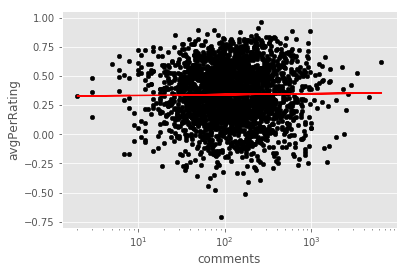

In [8]:
df.plot.scatter(x='comments',y='avgPerRating',color='black')
coeffs = plotTrendLine('comments','avgPerRating',logx=True);
plot.xscale('log')
print("Slope: "+str(coeffs[0]))

Slope: 0.0182969786616


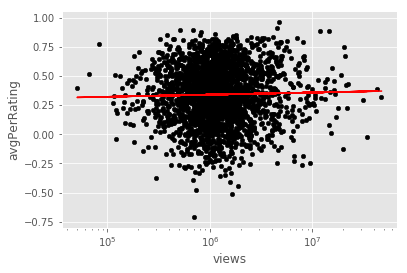

In [9]:
df.plot.scatter(x='views',y='avgPerRating',color='black')
coeffs = plotTrendLine('views','avgPerRating',logx=True);
plot.xscale('log')
print("Slope: "+str(coeffs[0]))

This is more interesting. While more comments seem to indicate higher ratings per view, the opposite is true for number of views.

## Machine Learning ##

What about trying to predict a rating based on various factors? This is where machine learning comes in. First, we want to select relevant features.

In [10]:
df.sample()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,aggregateRatings,totalRatings,avgPerRating
2419,15,"Emtithal ""Emi"" Mahmoud writes poetry of resili...",651,TEDMED 2016,1480464000,11,Emtithal Mahmoud,Emtithal Mahmoud: A young poet tells the story...,1,1490973136,"[{'id': 1, 'name': 'Beautiful', 'count': 241},...","[{'id': 2649, 'hero': 'https://pe.tedcdn.com/i...",Poet,"['Africa', 'TEDMED', 'art', 'children', 'commu...",A young poet tells the story of Darfur,https://www.ted.com/talks/emtithal_mahmoud_a_y...,822049,496,694,0.714697


From the sample, there are 7 numeric features that we can use:

In [11]:
mldf = df[['num_speaker','duration','comments','languages','views', 'film_date', 'published_date']]

Currently, this just consists of numerical values which already exist in the TED talks data set. However, it leaves out a lot of factors, such as the title and description of the talk. We can analyze these with natural language processing. 

There are a few approaches that can be taken. One of the possibilities is to perform a sentiment analysis on the description (or possibly the title) and consider this a feature. We can do this with the TextBlob library:

In [12]:
mldf['descriptionSentiment'] = df['description'].apply(lambda x:TextBlob(re.sub(r'[^\x00-\x7f]',r'',x)).sentiment.polarity)
print("Sentiment: ")
print(mldf['descriptionSentiment'].head())
print("Description: ")
print(df['description'].head())

Sentiment: 
0    0.291667
1   -0.115909
2   -0.081981
3    0.000000
4    0.000000
Name: descriptionSentiment, dtype: float64
Description: 
0    Sir Ken Robinson makes an entertaining and pro...
1    With the same humor and humanity he exuded in ...
2    New York Times columnist David Pogue takes aim...
3    In an emotionally charged talk, MacArthur-winn...
4    You've never seen data presented like this. Wi...
Name: description, dtype: object


We can also analyze tags and the event location. We can create a one-hot encoding: 

In [18]:
mldf['encodedEvent'] = preprocessing.LabelBinarizer().fit_transform(df['event']).tolist()

df['tags'] = df['tags'].apply(lambda x:eval(str(x)))
all_tags = {}
count = 0
for talk in df['tags']:
    for tag in talk:
        if not tag in all_tags:
            all_tags[tag] = count
            count = count+1
onehot = np.zeros((0,count))
for talk in df['tags']:
    temp = np.zeros((1,count))
    for tag in talk:
        temp[0,all_tags[tag]] = 1
    onehot = np.concatenate((onehot,temp),0)

Now we are ready to create the machine learning model. Our model will be a neural network, implemented in Keras using a TensorFlow backend. We first create the training and validation data sets, then we create the model.

In [19]:
mldf_np = mldf.as_matrix()
all_y = np.reshape(df['avgPerRating'].as_matrix(),(-1,1))
all_x = np.concatenate((mldf_np,onehot),1)
combined = np.concatenate((all_x,all_y),1)
np.random.shuffle(combined)
data_size = np.shape(all_y)[0]
train_size = (int)(data_size*0.75)
feature_size = np.shape(all_x)[1]
x_train = combined[0:train_size,0:feature_size]
y_train = combined[0:train_size,feature_size]
x_val = combined[train_size:data_size,0:feature_size]
y_val = combined[train_size:data_size,feature_size]

In [22]:
model = Sequential()
model.add(Dense(64,input_dim=feature_size,kernel_regularizer=l2(0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer="adam")
history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=20,validation_data=(x_val,y_val))

Train on 1912 samples, validate on 638 samples
Epoch 1/20


ValueError: setting an array element with a sequence.

From the steadily decreasing loss on both test and validation data sets, it's clear that this neural network works fairly well. We can graph the losses:  

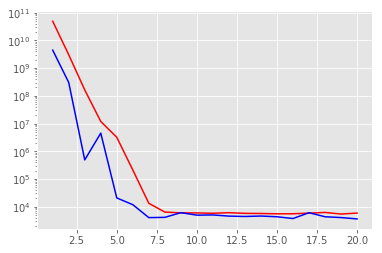

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1,21)
plot.plot(epochs,loss,color='red')
plot.plot(epochs,val_loss,color='blue')
plot.yscale('log')

While this neural network works well, it is possibly difficult to interpret due to the hidden layer. Thus, we also train a simpler version, with no hidden layer and linear activation. 

In [1]:
model = Sequential()
model.add(Dense(1,input_dim=feature_size))
model.compile(loss='mean_squared_error',optimizer="adam")
history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=20,validation_data=(x_val,y_val))

NameError: name 'Sequential' is not defined

We can graph the loss for this network as well. 

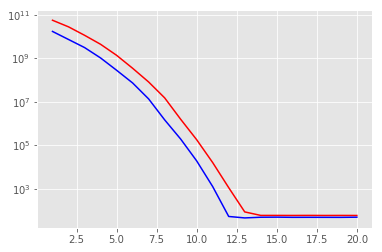

In [96]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1,21)
plot.plot(epochs,loss,color='red')
plot.plot(epochs,val_loss,color='blue')
plot.yscale('log')

This neural network has the benefit of being easier to understand. As this neural network has linear activation with no hidden layers, its weights can be interpreted as directly affecting the final rating per view. A positive weight would indicate some correlation between that feature and rating per view, and vice versa.

## Factor Analysis ##

We first split the weights into two categories. existing_weights consists of the existing numerical features in the data set, as well as the sentiment of the description. tag_weights, a larger set of features, consists of the weights of each TED talk tag. 

In [97]:
all_weights_temp = model.layers[0].get_weights()[0]
all_weights = []
for weight in all_weights_temp:
    all_weights.append(weight[0])
existing_weights = all_weights[:6]
tag_weights = all_weights[6:]

Let's first examine the relationship between rating per view and the existing numerical features in the data set. 

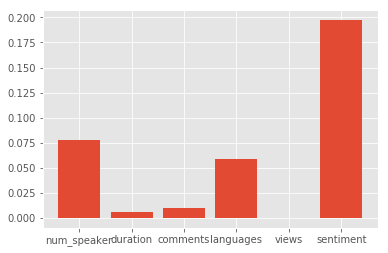

In [107]:
fig,ax = plot.subplots()
index = np.arange(0,6)
ax.bar(index,existing_weights)
ax.set_xticklabels(('','num_speaker','duration','comments','languages','views','sentiment'))
plot.show()

Examining each feature in order: 

* Number of speakers: large positive coefficient. Talks with multiple speakers seem to be recieved more positively, possibly due to the novelty.


* Duration: Insignificant. Longer talks might tend to bore the audience, perhaps scoring poorly on "longwinded" or "obnoxious" ratings, but they may also have more of a chance to convey their message.


* Comments: coefficient on the comments feature is slightly positive. It seems that talks rated highly are more likely to stimulate discussion, as one might expect.


* Languages: large positive coefficient. Translating talks into different languages seems to garner positive ratings.


* Views: coefficient very close to zero. As we already control for this by dividing total ratings by views, this is probably not a surprise.


* Sentiment: large positive coefficient. Talks with positive descriptions tend to also have higher ratings per viewer, which seems intuitive.

Now let's examine the different tags: 

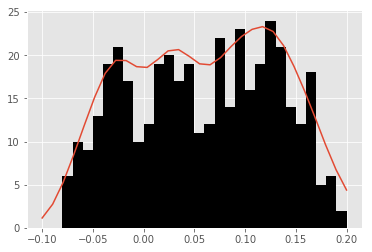

In [129]:
plot.hist(x=tag_weights,bins=30,range=(-0.1,0.2),color='black')
plotDensityCurve(tag_weights,(-0.1,0.2,30),0.25,5,data=None)

We see that the distribution of tag weights follows a multimodal distribution, with one peak around -0.02 (slightly negative coefficient), one peak around 0.03 (slightly positive coefficient), and one peak around 0.13 (large positive coefficient). Which tags are most strongly correlated with high ratings per view?

In [130]:
inverted_tags = dict([v,k] for k,v in all_tags.items())
tag_columns = ('features',)
tag_df = pd.DataFrame({'features': tag_weights})
best_tags = tag_df.sort_values('features',ascending=False).head(10).index.tolist()
for tag in best_tags:
    print(inverted_tags[tag])

art
sustainability
nature
activism
business
DNA
physics
medicine
security
communication


These are the most inversely correlated: 

In [131]:
worst_tags = tag_df.sort_values('features',ascending=True).head(10).index.tolist()
for tag in worst_tags:
    print(inverted_tags[tag])

vocals
urban
mindfulness
sleep
mobility
typography
HIV
population
flight
dance


It's quite possible this analysis suffers from small sample size. Some tags might have very few talks, skewing the ratings per view excessively. The following code is credited to Rounak Banik for finding the most popular tags: 

In [132]:
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'
theme_df = df.drop('tags', axis=1).join(s)
theme_df.head()
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
top_themes = pop_themes.head(20)
top_themes

,theme,talks
0,technology,727
1,science,567
2,global issues,501
3,culture,486
4,TEDx,450
5,design,418
6,business,348
7,entertainment,299
8,health,236
9,innovation,229


The most popular themes for talks, sorted by rating per view coefficient: 

In [134]:
top_theme_list = []
for theme in top_themes['theme'].tolist():
    top_theme_list.append((theme,tag_df['features'].tolist()[all_tags[theme]]))
sorted_list = sorted(top_theme_list,key=lambda x: -x[1])
theme_list = []
weight_list = []
for pair in sorted_list:
    theme_list.append(pair[0])
    weight_list.append(pair[1])

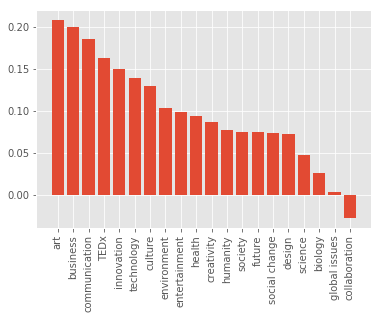

In [140]:
fig,ax = plot.subplots()
index = np.arange(0,20)
ax.bar(index,weight_list)
ax.set_xticklabels(theme_list)
plot.xticks(index)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plot.show()

We see that art, business, communication, and TEDx tend to generate the highest ratings per view. Almost every popular tag has a positive correlation, except collaboration, which ranks the lowest.

## Summary ##

In this analysis a unified, quantitative measure of rating (aggregate rating per view) was extracted from the data set. Two neural networks were trained on various features, including talk sentiment and themes, to predict this measure, achieving good accuracy. The relationship between ratings and these features was determined through examining the weights of the single-layer neural network.